In [2]:
import os
from glob import glob
import logging
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bids import BIDSLayout
import nibabel as nib
from nistats.design_matrix import make_first_level_design_matrix, make_second_level_design_matrix
from nistats.design_matrix import check_design_matrix
from nistats.reporting import plot_design_matrix, plot_contrast_matrix
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.model import TContrastResults
from nilearn import surface
from nilearn.image import concat_imgs, mean_img
from nilearn.plotting import plot_stat_map, plot_anat, plot_epi, plot_img, show

def format_events(event_file):
    """
    Argument:
        event_file Full path to events.tsv file
    
    Output:
        event_df Newly formatted events dataframe
    """
    #Read in tsv file
    event_df = pd.read_csv(event_file,delimiter='\t')
    
    #Filter out the desired columns from event_df 
    event= event_df[['trial_type','onset','duration']]
    
    #Define EA and Circle video trial types
    EA_videos = event[event_df['trial_type'] == 'EA_block']
    #EA_videos['block_score'].values[:]=0
    circle_videos = event[event_df['trial_type'] == 'circle_block']
    #circle_videos['block_score'].values[:]=0
    
    #Define button press event type from dataframe
    button_press = event_df[['onset','event_type','stim_file','duration']]
    button_press = button_press[button_press['event_type'] == 'button_press']

    #Filter button press during circle stimulus
    circle_button_press = button_press[button_press['stim_file'].str.match("circles")]
    EA_button_press = button_press[button_press['stim_file'].str.match("NW|AR|TA|CT|ME|HR|DH")]
    
    #Rename the button_press during circle block to circle button press
    circle_button_press=circle_button_press.reset_index(drop=True)
    circle_button_press.loc[:,'event_type'] = 'circle_button_press'
    EA_button_press=EA_button_press.reset_index(drop=True)
    EA_button_press.loc[:,'event_type'] = 'EA_button_press'
    EA_button_press["event_type"].replace({"button_press": "EA_button_press"}, inplace=True)   

    #Merge EA and circle button press together
    df_button_press = pd.concat([EA_button_press,circle_button_press])

    #Drop stim_file column in the button press dataframe
    df_button_press.drop(['stim_file'], axis=1,inplace=True)
    
    #Convert all NaN values in block_score column into zero
    #df_button_press['block_score'].values[:]=0
    
    #Rename event_type column to trial_type in button press df
    df_button_press.rename(columns={"event_type": "trial_type"}, inplace=True)
    
    #Merge all the event types together
    new_event_df = pd.concat([EA_videos,circle_videos,df_button_press])
    
    #new_event_df.rename(columns={"block_score": "modulation"}, inplace=True)
    new_event_df=new_event_df.reset_index(drop=True)
    
    #Adjust for deleted TRs at start of run
    new_event_df.loc[:,"onset"] = new_event_df["onset"].apply(lambda x: x - 8)
    #final_df.to_csv('/projects/ttan/fMRI_tools/sub-CMH0012_EA_onsets_run-01_fixed.tsv', sep = '\t')
    
    return new_event_df


<ipython-input-2-3810fabce4cc>:12: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.design_matrix import make_first_level_design_matrix, make_second_level_design_matrix
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [28]:
%matplotlib inline
pd.set_option('display.max_row',150)
event_df=format_events('/mnt/tigrlab/projects/ttan/fMRI_tools/data/preprocessed/sub-CMH0058/SPN01_CMH_0058_01_01_EAtask_part1.tsv')
event_df

,trial_type,onset,duration
0,EA_block,5.1894,170.0
1,EA_block,225.5169,146.0
2,EA_block,421.8377,111.0
3,circle_block,180.3475,40.0
4,circle_block,376.6690,40.0
5,EA_button_press,23.5945,0.0
6,EA_button_press,44.0726,0.0
7,EA_button_press,57.2955,0.0
8,EA_button_press,75.6338,0.0
9,EA_button_press,80.2643,0.0


In [3]:
# def extract_confounds(confound_path,fixed_confound_path, confound_vars):
#     """
#     Arguments:
#         confound_path    Full path to confounds.tsv
#         confound_vars    List of confound variables to extract
#         tr_drop
#         dt               Compute temporal derivatives [default = True]
#         sq               Compute quadratic terms [default = False]
    
#     Outputs:
#         confound_df
#     """
    
#     # Load in data using pandas and extract the relevant columns
#     confound_df = pd.read_csv(confound_path, delimiter='\t')
#     confound_df = confound_df[confound_vars]
    
#     #Load in the fixed csf and white matter data
#     fixed_confound_df = pd.read_csv(fixed_confound_path, delimiter='\t')  
#     confound_df = confound_df.assign(csf_fixed=fixed_confound_df['csf_fixed'],
#                                      white_matter_fixed=fixed_confound_df['white_matter_fixed'])
    
#     # During the initial stages of a functional scan there is a strong signal decay artifact
#     # The first few TRs are very high intensity signals that don't reflect the rest of the scan
#     # so they are dropped
#     tr_drop=4
#     confound_df = confound_df.loc[tr_drop:].reset_index(drop=True)
    
#     #demean all the confounds
#     for col in confound_df.columns:
#         confound_df[col] = confound_df[col].sub(confound_df[col].mean())
        
#     # Return confound matrix
#     return confound_df

In [3]:
def format_confounds_tsv(sub_path):    
    """
    input      full-path to the subject directory where the confounds tsv files are stored
    
    output     a list of demeand tsv confounds in data frame format across multiple runs
        
    """
    #Hard-code variable, need to be updated
    runs=['1','2','3']
    path_head,path_tail = os.path.split(sub_path)
    sub_id = path_tail.replace('sub-CMH', '')
    combined_confounds_df=[]
    for run in runs:
        tsv_template="sub-CMH{sub_id}_ses-01_task-emp_run-{run}_desc-confounds_regressors.tsv"
        tsv_file=os.path.join(sub_path,tsv_template.format(sub_id=sub_id,run=run))
        confound_df = pd.read_csv(tsv_file,delimiter='\t')
        confound_df = confound_df[confound_vars]
        fixed_tsv_template="sub-CMH{sub_id}_ses-01_task-emp_run-{run}_desc-confounds_regressors_fixed.tsv"
        fixed_tsv_file=os.path.join(sub_path, fixed_tsv_template.format(sub_id=sub_id,run=run))
        
        fixed_confound_df = pd.read_csv(fixed_tsv_file,delimiter='\t')
        
        confound_df = confound_df.assign(csf_fixed=fixed_confound_df['csf_fixed'],
                                         white_matter_fixed=fixed_confound_df['white_matter_fixed'])
        tr_drop=4
        confound_df = confound_df.loc[tr_drop:].reset_index(drop=True)
        combined_confounds_df.append(confound_df)
    
    #Concat the confound_df into one df for demeaning across 3 runs
    tmp_df=pd.concat([combined_confounds_df[0],combined_confounds_df[1],combined_confounds_df[2]],ignore_index=True,sort=False)
    tmp_df.drop(columns=['csf','white_matter'],inplace=True)
    for col in tmp_df.columns:
        tmp_df[col] = tmp_df[col].sub(tmp_df[col].mean())
    
    #Split the demeaned combined df into a list of 3 df      
    tmp_df=np.array_split(tmp_df,3)
    
#     for idx,run in enumerate(runs):
#         output_confound_tsv="sub-CMH{sub_id}_ses-01_task-emp_run-{run}_desc-confounds_regressors_demeaned.tsv"
#         output=os.path.join(sub_path,output_confound_tsv.format(sub_id=sub_id,run=run))
#         tmp_df[idx].to_csv(output,index=False,sep = '\t')
#         print('Generating OutPut')
    return tmp_df
    

In [18]:
confound_vars = ['csf','white_matter','framewise_displacement',
                 'trans_x','trans_y','trans_z',
                 'trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x','rot_y','rot_z',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
                ]
confound_df=format_confounds_tsv('/projects/ttan/fMRI_tools/data/preprocessed/sub-CMH0120')
confound_df[0]

,framewise_displacement,trans_x,trans_y,trans_z,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x,rot_y,rot_z,rot_x_derivative1,rot_y_derivative1,rot_z_derivative1,csf_fixed,white_matter_fixed
0,0.016742,0.041215,0.049124,-0.079087,0.021768,0.000087,0.059022,0.002676,-0.000317,0.000073,-3.929173e-04,-0.000338,-3.038819e-04,1.136137,20.355168
1,-0.076985,0.041215,0.069947,-0.089134,0.000171,0.021080,-0.010837,0.002854,-0.000317,0.000073,1.842497e-04,-0.000001,-9.249182e-07,12.784132,22.129436
2,-0.045890,0.041072,0.071235,-0.044238,0.000028,0.001545,0.044106,0.003079,-0.000140,-0.000016,2.306037e-04,0.000176,-9.027892e-05,23.301995,20.914019
3,-0.044606,0.041169,0.069039,0.004558,0.000267,-0.001939,0.048006,0.003310,-0.000241,0.000073,2.376227e-04,-0.000102,8.843008e-05,-8.657941,11.668635
4,-0.023333,0.059627,0.088339,-0.019099,0.018629,0.019557,-0.024447,0.003732,-0.000317,0.000215,4.279667e-04,-0.000078,1.409211e-04,-8.508171,11.704788
5,-0.034583,0.057588,0.068385,-0.052957,-0.001868,-0.019697,-0.034648,0.003317,-0.000241,0.000251,-4.086463e-04,0.000075,3.463208e-05,10.655737,14.324223
6,-0.050895,0.059547,0.066654,-0.028051,0.002130,-0.001474,0.024116,0.002825,-0.000317,0.000073,-4.856603e-04,-0.000077,-1.783279e-04,10.277435,16.940750
7,-0.066335,0.055459,0.058586,-0.026303,-0.003918,-0.007811,0.000958,0.003336,-0.000317,0.000293,5.169087e-04,-0.000001,2.187161e-04,1.378393,17.712347
8,-0.063875,0.045606,0.068879,-0.046361,-0.009682,0.010550,-0.020848,0.003445,-0.000224,0.000242,1.144757e-04,0.000093,-5.248492e-05,0.962500,18.080575
9,-0.059929,0.059637,0.047732,-0.031725,0.014202,-0.020890,0.013846,0.003439,-0.000233,0.000367,1.336813e-07,-0.000010,1.241851e-04,-8.263528,11.754340


In [7]:
pd.set_option('display.max_row',450)
drift_model = 'polynomial'
drift_order = 5
hrf_model = 'spm'
noise_model = 'ar1'
files = os.listdir('/projects/ttan/fMRI_tools/data/preprocessed/sub-CMH0120')
event_file = os.path.join('/projects/ttan/fMRI_tools/data/preprocessed/sub-CMH0120/',next(f for f in files if f.endswith('EAtask_part1.tsv')))
nifti_img = os.path.join('/projects/ttan/fMRI_tools/data/preprocessed/sub-CMH0120/', next(f for f in files if f.endswith('run-1_desc-preproc_Atlas_s6.nii')))

In [4]:
def format_pmod_event(sub_input_path):
    """
    input      full-path to the subject directory where the task event files are stored
    
    output     a list of demeaned pmod values in data frame format
    
    """
    runs=['1','2','3']
    path_head,path_tail = os.path.split(sub_input_path)
    sub_id = path_tail.replace('sub-CMH', '')
    combined_pmod_event=[]
    for run in runs:
        event_file="SPN01_CMH_{sub_id}_01_01_EAtask_part{run}.tsv"
        event_file=os.path.join(sub_input_path, event_file.format(sub_id=sub_id,run=run))
        event = pd.read_csv(event_file,delimiter='\t')
        event= event[['trial_type','onset','duration','block_score']]
        event.loc[:,"onset"] = event["onset"].apply(lambda x: x - 8)
        EA_videos_pmod = event[event['trial_type']=='EA_block']
        EA_videos_pmod=EA_videos_pmod.reset_index(drop=True)
        EA_videos_pmod.rename(columns= {"block_score": "modulation"}, inplace=True)
        combined_pmod_event.append(EA_videos_pmod)
    tmp_df=pd.concat([combined_pmod_event[0],combined_pmod_event[1],combined_pmod_event[2]],ignore_index=True,sort=False)
    tmp_df['modulation']= tmp_df['modulation'] - tmp_df['modulation'].mean()
    tmp_df["trial_type"].replace({"EA_block": "EA_pmod"}, inplace=True)
    final_pmod_events=np.array_split(tmp_df,3)
    return final_pmod_events
    
#     for idx,run in enumerate(runs):
#         output_pmod_tsv="sub-CMH{sub_id}_EA_pmod_part{run}.tsv"
#         output=os.path.join(sub_input_path,output_pmod_tsv.format(sub_id=sub_id,run=run))
#         final_pmod_events[idx].to_csv(output,sep = '\t')
#         print('Generating OutPut')
#     return final_pmod_events


        

In [20]:
pmod_df=format_pmod_event('/projects/ttan/fMRI_tools/data/preprocessed/sub-CMH0120')
pmod_df

[  trial_type     onset  duration  modulation
 0    EA_pmod    5.3733     170.0   -0.005494
 1    EA_pmod  226.1002     146.0   -0.038103
 2    EA_pmod  422.4376     111.0    0.142283,
   trial_type     onset  duration  modulation
 3    EA_pmod    5.2227     144.0    0.013952
 4    EA_pmod  199.5685     137.0    0.032513
 5    EA_pmod  386.9314     147.0    0.042748,
   trial_type     onset  duration  modulation
 6    EA_pmod    5.1893     119.0    0.047724
 7    EA_pmod  174.5794     179.0    0.106949
 8    EA_pmod  403.9155     130.0   -0.342573]

In [5]:
def get_dm_pmod(fmri_img,EA_videos_pmod,confound_df):
    """
    Arguments:
        fmri_img         full path to nifti outputs
        EA_videos_pmod   output from format_pmod_event
        confound_df      output from format_confounds_tsv
    
    Outputs:
        dm_pm
    """

    #Calculate frame times
    func_img = nib.load(fmri_img)
    n_scans = func_img.shape[-1]
    tr=2
    frame_times = np.arange(n_scans)*tr
    
    # create design matrix with modulation
    dm_pm = make_first_level_design_matrix(frame_times,EA_videos_pmod,
                                           drift_model=drift_model,
                                           drift_order=drift_order,
                                           add_regs=confound_df,
                                           add_reg_names=list(confound_df.columns),
                                           hrf_model=hrf_model
                                          )
    return dm_pm

In [22]:
dm_pmod_0120=get_dm_pmod(nifti_img,pmod_df[0],confound_df[0])
dm_pmod_0120


/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nistats/experimental_paradigm.py:65: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")


,EA_pmod,framewise_displacement,trans_x,trans_y,trans_z,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x,rot_y,...,rot_y_derivative1,rot_z_derivative1,csf_fixed,white_matter_fixed,drift_1,drift_2,drift_3,drift_4,drift_5,constant
0,0.000000e+00,0.016742,0.041215,0.049124,-0.079087,0.021768,0.000087,0.059022,0.002676,-0.000317,...,-0.000338,-3.038819e-04,1.136137,20.355168,-5.000000e-01,0.166054,-0.049450,0.013973,-3.824230e-03,1.0
2,0.000000e+00,-0.076985,0.041215,0.069947,-0.089134,0.000171,0.021080,-0.010837,0.002854,-0.000317,...,-0.000001,-9.249182e-07,12.784132,22.129436,-4.963235e-01,0.162391,-0.047268,0.012945,-3.402440e-03,1.0
4,0.000000e+00,-0.045890,0.041072,0.071235,-0.044238,0.000028,0.001545,0.044106,0.003079,-0.000140,...,0.000176,-9.027892e-05,23.301995,20.914019,-4.926471e-01,0.158755,-0.045127,0.011952,-3.002440e-03,1.0
6,-2.131925e-07,-0.044606,0.041169,0.069039,0.004558,0.000267,-0.001939,0.048006,0.003310,-0.000241,...,-0.000102,8.843008e-05,-8.657941,11.668635,-4.889706e-01,0.155146,-0.043025,0.010992,-2.623584e-03,1.0
8,-3.153045e-04,-0.023333,0.059627,0.088339,-0.019099,0.018629,0.019557,-0.024447,0.003732,-0.000317,...,-0.000078,1.409211e-04,-8.508171,11.704788,-4.852941e-01,0.151564,-0.040964,0.010065,-2.265237e-03,1.0
10,-2.056092e-03,-0.034583,0.057588,0.068385,-0.052957,-0.001868,-0.019697,-0.034648,0.003317,-0.000241,...,0.000075,3.463208e-05,10.655737,14.324223,-4.816176e-01,0.148009,-0.038941,0.009171,-1.926776e-03,1.0
12,-4.243248e-03,-0.050895,0.059547,0.066654,-0.028051,0.002130,-0.001474,0.024116,0.002825,-0.000317,...,-0.000077,-1.783279e-04,10.277435,16.940750,-4.779412e-01,0.144482,-0.036958,0.008308,-1.607587e-03,1.0
14,-5.635653e-03,-0.066335,0.055459,0.058586,-0.026303,-0.003918,-0.007811,0.000958,0.003336,-0.000317,...,-0.000001,2.187161e-04,1.378393,17.712347,-4.742647e-01,0.140981,-0.035013,0.007477,-1.307067e-03,1.0
16,-6.200115e-03,-0.063875,0.045606,0.068879,-0.046361,-0.009682,0.010550,-0.020848,0.003445,-0.000224,...,0.000093,-5.248492e-05,0.962500,18.080575,-4.705882e-01,0.137507,-0.033107,0.006676,-1.024623e-03,1.0
18,-6.280433e-03,-0.059929,0.059637,0.047732,-0.031725,0.014202,-0.020890,0.013846,0.003439,-0.000233,...,-0.000010,1.241851e-04,-8.263528,11.754340,-4.669118e-01,0.134061,-0.031239,0.005905,-7.596735e-04,1.0


In [6]:
#remove modulation column from event_df
#event = event_df[['onset','duration','trial_type']]
#Create a design matrix with pmod as the reressor
def get_design_matrix(fmri_img,event_file,dm_pm):
    """
    Arguments:
    fmri_img        full path to functional data
    event_file      full path to event tsv file
    dm_pm           pmod design matrix from get_dm_pmod
    
    Output:
    
    dm              a full design matrix
    """

    
    event=format_events(event_file)

    func_img = nib.load(fmri_img)
    n_scans = func_img.shape[-1]
    tr=2
    frame_times = np.arange(n_scans)*tr
    dm = make_first_level_design_matrix(frame_times,
                                        event,drift_model=drift_model,
                                        drift_order=drift_order,
                                        add_regs=dm_pm
                                        [['EA_pmod','csf_fixed',
                                          'white_matter_fixed',
                                          'framewise_displacement',
                                          'trans_x','trans_x_derivative1',
                                          'trans_y','trans_y_derivative1',
                                          'trans_z','trans_z_derivative1',
                                          'rot_x','rot_x_derivative1',
                                          'rot_y','rot_y_derivative1',
                                          'rot_z','rot_z_derivative1']],
                                        add_reg_names=['EA_pmod','csf_fixed',
                                          'white_matter_fixed',
                                          'framewise_displacement',
                                          'trans_x','trans_x_derivative1',
                                          'trans_y','trans_y_derivative1',
                                          'trans_z','trans_z_derivative1',
                                          'rot_x','rot_x_derivative1',
                                          'rot_y','rot_y_derivative1',
                                          'rot_z','rot_z_derivative1'],
                                        hrf_model=hrf_model,)
    return dm


In [25]:
dm_0120_01=get_design_matrix(nifti_img,event_file,dm_pmod_0120)
dm_0120_01

,EA_block,EA_button_press,circle_block,circle_button_press,EA_pmod,csf_fixed,white_matter_fixed,framewise_displacement,trans_x,trans_x_derivative1,...,rot_y,rot_y_derivative1,rot_z,rot_z_derivative1,drift_1,drift_2,drift_3,drift_4,drift_5,constant
0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.136137,20.355168,0.016742,0.041215,0.021768,...,-0.000317,-0.000338,0.000073,-3.038819e-04,-5.000000e-01,0.166054,-0.049450,0.013973,-3.824230e-03,1.0
2,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,12.784132,22.129436,-0.076985,0.041215,0.000171,...,-0.000317,-0.000001,0.000073,-9.249182e-07,-4.963235e-01,0.162391,-0.047268,0.012945,-3.402440e-03,1.0
4,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,23.301995,20.914019,-0.045890,0.041072,0.000028,...,-0.000140,0.000176,-0.000016,-9.027892e-05,-4.926471e-01,0.158755,-0.045127,0.011952,-3.002440e-03,1.0
6,0.000039,0.000000e+00,0.000000,0.000000,-2.131925e-07,-8.657941,11.668635,-0.044606,0.041169,0.000267,...,-0.000241,-0.000102,0.000073,8.843008e-05,-4.889706e-01,0.155146,-0.043025,0.010992,-2.623584e-03,1.0
8,0.057390,0.000000e+00,0.000000,0.000000,-3.153045e-04,-8.508171,11.704788,-0.023333,0.059627,0.018629,...,-0.000317,-0.000078,0.000215,1.409211e-04,-4.852941e-01,0.151564,-0.040964,0.010065,-2.265237e-03,1.0
10,0.374240,0.000000e+00,0.000000,0.000000,-2.056092e-03,10.655737,14.324223,-0.034583,0.057588,-0.001868,...,-0.000241,0.000075,0.000251,3.463208e-05,-4.816176e-01,0.148009,-0.038941,0.009171,-1.926776e-03,1.0
12,0.772336,0.000000e+00,0.000000,0.000000,-4.243248e-03,10.277435,16.940750,-0.050895,0.059547,0.002130,...,-0.000317,-0.000077,0.000073,-1.783279e-04,-4.779412e-01,0.144482,-0.036958,0.008308,-1.607587e-03,1.0
14,1.025775,0.000000e+00,0.000000,0.000000,-5.635653e-03,1.378393,17.712347,-0.066335,0.055459,-0.003918,...,-0.000317,-0.000001,0.000293,2.187161e-04,-4.742647e-01,0.140981,-0.035013,0.007477,-1.307067e-03,1.0
16,1.128516,0.000000e+00,0.000000,0.000000,-6.200115e-03,0.962500,18.080575,-0.063875,0.045606,-0.009682,...,-0.000224,0.000093,0.000242,-5.248492e-05,-4.705882e-01,0.137507,-0.033107,0.006676,-1.024623e-03,1.0
18,1.143135,0.000000e+00,0.000000,0.000000,-6.280433e-03,-8.263528,11.754340,-0.059929,0.059637,0.014202,...,-0.000233,-0.000010,0.000367,1.241851e-04,-4.669118e-01,0.134061,-0.031239,0.005905,-7.596735e-04,1.0


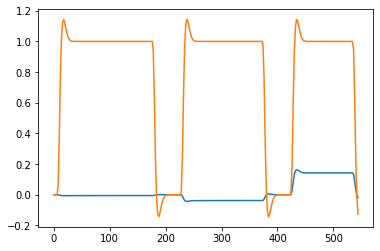

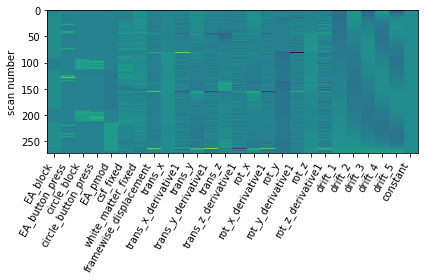

In [29]:
dm_0120_01
plt.plot(dm_0120_01[['EA_pmod','EA_block']])
plot_design_matrix(dm_0120_01)

In [ ]:
# paths
base_path='/projects/ttan/fMRI_tools'
input_path='{}/data/preprocessed'.format(base_path)
out_path='{}/'.format(base_path)

fmri_sub=os.path.join(input_path,'{subject}')
#fmri_file='{subject}_ses-01_task-{task}_run-{run}_desc-preproc_Atlas_s6.nii'
#cifti_file='{subject}_ses-01_task-{task}_run-{run}_desc-preproc_Atlas_s6.dtseries.nii'
#event_file='SPN01_CMH_{sub_id}_01_01_EMP_part{run}.tsv'
#confound_file='{subject}_ses-01_task-{task}_run-{run}_desc-confounds_regressors.tsv'
#fixed_confound_file='{subject}_ses-01_task-{task}_run-{run}_desc-confounds_regressors_fixed.tsv'

# scan parameter
with open('/projects/ttan/fMRI_tools/lists/subs.txt','r') as f:
    lines = f.read().split('\n')
subjects = [i for i in lines[:-1]]
subs_id = [i.replace('sub-CMH', '') for i in lines][:-1]
#df=pd.DataFrame(subs_id)
#df.to_csv('/projects/ttan/fMRI_tools/lists/subs_id.csv',index=False)


task='emp'
runs= ['1','2','3']

#Define the time repettion from bid json file 
import os
data_dir='/archive/data/SPINS/data/bids'
json_file = os.path.join(data_dir,'sub-CMH0012', 'ses-01/func',
                         'sub-CMH0012_ses-01_task-emp_run-1_bold.json')
import json
with open(json_file, 'r') as f:
    t_r = json.load(f)['RepetitionTime']
tr_drop=4    
#t_r=2
#frame_times = np.arange(n_scans)*t_r

# design matrix input
drift_model = 'polynomial'
drift_order = 5
hrf_model = 'spm'

# first level model input
noise_model = 'ar1'

In [ ]:
#Generate the design matrix for each session 
for subject in subjects:
    sub_id=subject.replace('sub-CMH','')
    sub_in_path=os.path.join(input_path,subject)
    print(sub_in_path)
    confound_vars = ['csf','white_matter','framewise_displacement',
                     'trans_x','trans_y','trans_z',
                     'trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                     'rot_x','rot_y','rot_z',
                     'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
                    ]
    #list of demeaned pmod values in data frame format
    EA_pmods_df=format_pmod_event(sub_in_path)
    #list of demeaned confounds regressors in data frame format
    confounds_df= format_confounds_tsv(sub_in_path)
    
    print(EA_pmods_df)
    print(confounds_df)
    out_dir = os.path.join(out_path,'test_across9vids',subject)
    print(out_dir)
    
    for idx,run in enumerate(runs):

        event_file="SPN01_CMH_{sub_id}_01_01_EAtask_part{run}.tsv"
        event_file=os.path.join(input_path,subject,event_file.format(sub_id=sub_id,run=run))
        print(event_file)
        fmri_sub=os.path.join(input_path,'{subject}')
        fmri_img=os.path.join(fmri_sub,'{subject}_ses-01_task-{task}_run-{run}_desc-preproc_Atlas_s6.nii')
        fmri_file=fmri_img.format(subject=subject,task=task,run=run)
        print(EA_pmods_df[idx],run)
        dm_pm = get_dm_pmod(fmri_file,EA_pmods_df[idx],confounds_df[idx])
        print(subject,run)
        dm = get_design_matrix(fmri_file,event_file,dm_pm)
        combined_dm_path = os.path.join(out_dir, '{}_ses-01_task-{}_run-{}_dm.tsv'.format(subject,task,run))
        try:
            os.makedirs(out_dir)
            print("Directory ", out_dir, " Created ")
        except FileExistsError:
            print("Directory ", out_dir, " already exists")
        print(subject)
        dm.to_csv(combined_dm_path, sep = '\t')

In [ ]:
global tr
global tr_drop
global drift_model
global drift_order
global hrf_model
global noise_model
global period_cut
global event_df
global confound_df
global frame_times

In [ ]:
#Fit the GLM model 
for subject in subjects:
    fmri_combined= [];
    first_lvl_dms= [];
    subj_outdir = os.path.join(out_path, 'test_across9vids',subject)
    print(subj_outdir)
    for run in runs:
        fmri_sub=os.path.join(input_path,'{subject}')
        fmri_img=os.path.join(fmri_sub,'{subject}_ses-01_task-{task}_run-{run}_desc-preproc_Atlas_s6.nii')
        fmri_file=fmri_img.format(subject=subject,task=task,run=run)
        print(fmri_file)
        fmri_combined.append(fmri_file)
        combined_dm_path = os.path.join(subj_outdir, '{}_ses-01_task-{}_run-{}_dm.tsv'.format(subject,task,run))
        print(combined_dm_path)
        dm=pd.read_csv(combined_dm_path,delimiter='\t',index_col=[0])
        print(dm)
        first_lvl_dms.append(dm)
    
    #Concat dm of three runs into one designmatrix    
#     combined_dm_path = os.path.join(subj_outdir, '{}_ses-01_task-{}_combined_dm.tsv'.format(subject,task))
#     tmp=pd.concat([first_lvl_dms[0],first_lvl_dms[1],first_lvl_dms[2]],ignore_index=True,sort=False)
#     print(tmp)
#     tmp.to_csv(combined_dm_path, sep = '\t') 
    
    #GLM model specification
    first_level_glm=FirstLevelModel(t_r=t_r, #TR 2
                                    noise_model=noise_model, #ar1
                                    standardize=False,
                                    hrf_model=hrf_model,     #spm
                                    drift_model=drift_model, #polynomial
                                    drift_order=drift_order, #5
                                    minimize_memory=False,
                                    #high_pass=.01,
                                    mask_img=False)
    
    #Fitting the GLM model to compute the fixed effects across multiple runs - this is equivalent to SPM/AFNI block-diagonally model
    first_level_glm = first_level_glm.fit(fmri_combined,design_matrices=first_lvl_dms)
    #Generate basic contrasts
    contrast_matrix = np.eye(dm.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                         for i, column in enumerate(dm.columns)])
    basic_contrasts['button_press_main'] = basic_contrasts['circle_button_press'] + basic_contrasts['EA_button_press']
    contrasts_id = ['EA_block','EA_pmod','circle_block','button_press_main'] 
    for i, val in enumerate(contrasts_id):
        t_map = first_level_glm.compute_contrast(basic_contrasts[contrasts_id[i]],
                                                 stat_type='t',
                                                 output_type='stat')
        print(contrasts_id[i])
        print(basic_contrasts[contrasts_id[i]])
        subject_tmap_path = os.path.join(subj_outdir,"{}_ses-01_task-{}_{}_t_map.nii.gz".format(subject,task,contrasts_id[i]))
        t_map.to_filename (subject_tmap_path)